In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy.signal import argrelextrema
import os

import sys
sys.path.append('../../')
from cad.calc.geo import Geo
from cad.calc.conv import freq_to_note_and_cent, note_name
import pandas as pd
import seaborn as sns


In [2]:
ls ../../

__pycache__/        cad/                experiments/        test.py
assets/             config.ini          getting_started.py  test2.py
bin/                didgelab/           notebooks/          web/
blender/            eval/               requirements.txt    zuordnungen.json


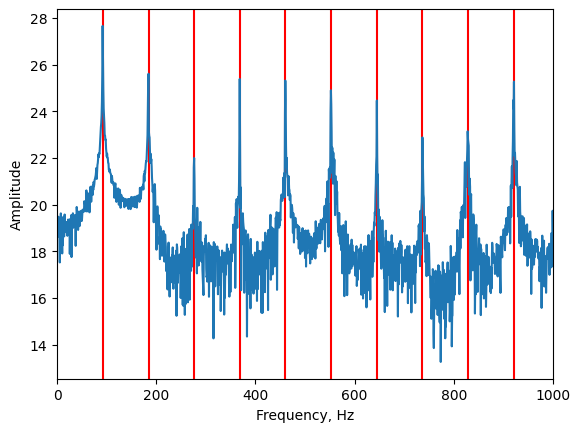

'{"note": {"0": "F#1", "1": "F#2", "9": "C#3", "2": "F#3", "3": "A#4", "5": "C#4", "6": "E4", "8": "F#4", "7": "G#4", "4": "A#5"}, "cent-diff": {"0": 10.976304776706769, "1": 4.430988666177171, "9": 4.6550114353010486, "2": 7.700553470020566, "3": 22.041494197620892, "5": 6.836781162076733, "6": 38.40718809456689, "8": 7.700553470020566, "7": 5.609648312064053, "4": 20.732432472438944}, "freq": {"0": 91.91400470014798, "1": 184.52432761772133, "9": 276.4383323178693, "2": 368.3523370180173, "3": 460.2663417181653, "5": 552.1803464183132, "6": 644.7906693358866, "8": 736.7046740360346, "7": 827.9223605187572, "4": 921.2290016537559}, "impedance": {"0": 212703466.9937342, "1": 51360481.26009979, "9": 4189237.0021876707, "2": 43956280.82140037, "3": 41948922.38472426, "5": 31435813.59818078, "6": 23187543.30085413, "8": 7746036.080585161, "7": 9296255.857709624, "4": 40586857.56672239}}'

In [3]:
# analyze peaks from the record

def do_fft(infile, size=-1, maxfreq=1000):
    sampFreq, sound = wavfile.read(infile)
    
    if len(sound.shape)==2:
        signal = sound[:,0]
    else:
        signal = sound

    if size == -1:
        size=len(signal)
    
    fft_spectrum = np.fft.rfft(signal, n=size)
    freq = np.fft.rfftfreq(size, d=1./sampFreq)
    fft_spectrum_abs = np.abs(fft_spectrum)
 
    i=0
    while i<len(freq) and freq[i]<=maxfreq:
        i+=1
    freq = freq[0:i]
    fft_spectrum_abs = fft_spectrum_abs[0:i]

    return freq, fft_spectrum_abs

# get peaks in fft
def get_n_peaks(freq, spectrum, n=10):
    # get all maxima
    peaks = []
    rising = True
    
    for i in range(1,len(spectrum)):
        if spectrum[i]<spectrum[i-1] and rising:
            rising = False
            peaks.append(i-1)
        if spectrum[i]>spectrum[i-1]:
            rising = True
            
    # get n highest maxima
    peaks = sorted(peaks, key=lambda x : spectrum[x], reverse=True)
    df = []
    for i in range(n):
        f = freq[peaks[i]]
        note, cent = freq_to_note_and_cent(f)
        imp = spectrum[peaks[i]]
        
        skip = False
        for j in range(len(df)):
            if np.abs(np.log2(df[j][2])-np.log2(f))<0.15:
                if imp>df[j][3]:
                    del df[j]
                    break
                else:
                    skip = True
                    break
        
        if not skip:
            df.append([note_name(note), cent, f, imp])
    
    df = pd.DataFrame(df, columns=["note", "cent-diff", "freq", "impedance"])
    
    
    
    return df
infile = "didgeridoo-samples/wav_short/4.wav"
freq, spectrum = do_fft(infile)
maxima = get_n_peaks(freq, spectrum, n=20).sort_values(by=["freq"])
maxima

infile = "didgeridoo-samples/wav_short/4.wav"
freq, fft_spectrum_abs=do_fft(infile)
freq, fft_spectrum_abs = do_fft(infile)
fft_spectrum_abs = np.log2(fft_spectrum_abs)

#for m in get_maxima(freq, np.exp(fft_spectrum_abs), 20)[0]:
for m in maxima.freq:
    plt.axvline(x=m, color="red")

plt.plot(freq, fft_spectrum_abs, label="sound")

plt.xlim((0,1000))

plt.xlabel("Frequency, Hz")
plt.ylabel("Amplitude")
plt.show()

maxima.to_csv("maxima_4.csv")

import json
json.dumps(maxima.to_dict())

In [4]:
maxima

,note,cent-diff,freq,impedance
0,F#1,10.976305,91.914005,2.127035e+08
1,F#2,4.430989,184.524328,5.136048e+07
9,C#3,4.655011,276.438332,4.189237e+06
2,F#3,7.700553,368.352337,4.395628e+07
3,A#4,22.041494,460.266342,4.194892e+07
5,C#4,6.836781,552.180346,3.143581e+07
6,E4,38.407188,644.790669,2.318754e+07
8,F#4,7.700553,736.704674,7.746036e+06
7,G#4,5.609648,827.922361,9.296256e+06
4,A#5,20.732432,921.229002,4.058686e+07


In [5]:
# loss function

from cad.calc.loss import LossFunction

class BlackEucaLoss(LossFunction):

    def __init__(self):
        self.reference = '{"note": {"0": "F#1", "1": "F#2", "9": "C#3", "2": "F#3", "3": "A#4", "5": "C#4", "6": "E4", "8": "F#4", "7": "G#4", "4": "A#5"}, "cent-diff": {"0": 10.976304776706769, "1": 4.430988666177171, "9": 4.6550114353010486, "2": 7.700553470020566, "3": 22.041494197620892, "5": 6.836781162076733, "6": 38.40718809456689, "8": 7.700553470020566, "7": 5.609648312064053, "4": 20.732432472438944}, "freq": {"0": 91.91400470014798, "1": 184.52432761772133, "9": 276.4383323178693, "2": 368.3523370180173, "3": 460.2663417181653, "5": 552.1803464183132, "6": 644.7906693358866, "8": 736.7046740360346, "7": 827.9223605187572, "4": 921.2290016537559}, "impedance": {"0": 212703466.9937342, "1": 51360481.26009979, "9": 4189237.0021876707, "2": 43956280.82140037, "3": 41948922.38472426, "5": 31435813.59818078, "6": 23187543.30085413, "8": 7746036.080585161, "7": 9296255.857709624, "4": 40586857.56672239}}'
        self.reference = pd.DataFrame(json.loads(self.reference))        
        self.reference["impedance_normalized"] = self.reference.impedance / self.reference.impedance.max()
        self.reference["logfreq"] = np.log2(self.reference.freq)
        
    def get_loss(self, geo):
        peaks = geo.get_cadsd().get_notes()
        peaks["logfreq"] = np.log2(peaks.freq)
        peaks["impedance_normalized"] = peaks.impedance / peaks.impedance.max()
        
        tuning_loss = []
        imp_loss = []
        for ix, peak in peaks.iterrows():
            mini = np.argmin([np.abs(peak.logfreq-f) for f in self.reference.logfreq])
            
            tl = np.abs(peak.logfreq-self.reference.logfreq[mini])
            il = np.abs(peak.impedance_normalized - self.reference.impedance_normalized[mini])
            tuning_loss.append(tl)
            imp_loss.append(il)
            # print(f"{self.reference.freq[mini]:.0f}, {peak.freq:.0f}, {tl:.2f}, {il:.2f}")

        fundamental_loss = tuning_loss[0]*10
        tuning_loss = np.sum(tuning_loss)
        imp_loss = np.sum(imp_loss)
        
        return {
            "loss": fundamental_loss + tuning_loss + imp_loss,
            "fundamental_loss": fundamental_loss,
            "tuning_loss": tuning_loss,
            "imp_loss": imp_loss
        }
    
geo = [[0,32], [800,32], [900,38], [970,42], [1050, 40], [1180, 48], [1350, 60], [1390, 68], [1500, 72]]
geo=Geo(geo)
BlackEucaLoss().get_loss(geo)

{'loss': 4.826852912240933,
 'fundamental_loss': 3.3832933384517094,
 'tuning_loss': 0.7992758726208375,
 'imp_loss': 0.6442837011683864}

<AxesSubplot: xlabel='x', ylabel='y'>

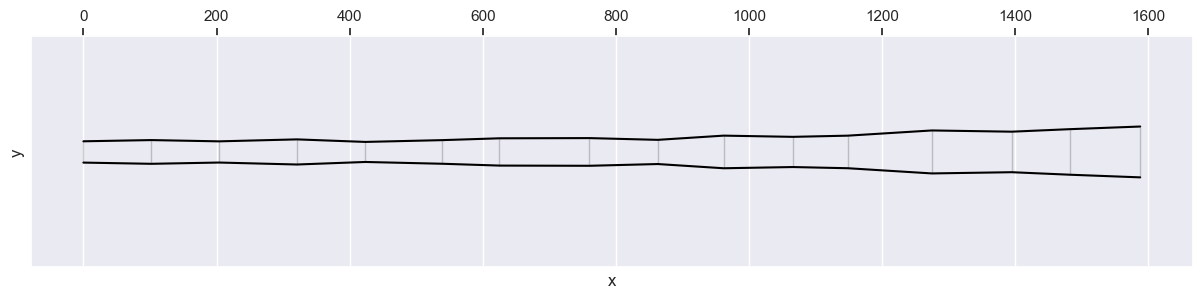

In [6]:
# shape

from cad.calc.parameters import MutationParameterSet, MutationParameter
from cad.ui.visualization import DidgeVisualizer
from cad.calc.mutation import ExploringMutator
import pandas as pd
import tqdm
import random

np.random.seed(0)
random.seed(0)
mutator = ExploringMutator()


class BlackEucaShape(MutationParameterSet):
    
    def __init__(self):
        
        MutationParameterSet.__init__(self)

        self.d1=32
        self.n_segments = 15
        
        self.add_param("length", 1520, 1600)
        self.add_param("bellsize", 65, 80)
        self.add_param("power", 1,2)
        
        for i in range(self.n_segments-1):
            self.add_param(f"delta_x{i}", -20, 20)
            self.add_param(f"delta_y{i}", 0.8, 1.2)
        

    def make_geo(self):
        length = self.get_value("length")
        bellsize = self.get_value("bellsize")

        x = length*np.arange(self.n_segments+1)/self.n_segments
    
        y= np.arange(self.n_segments+1)/self.n_segments
        p = self.get_value("power")
        y = np.power(y, p)
        y = np.power(y, p)
        y = np.power(y, p)
        y = self.d1 + y*(bellsize - self.d1)
        
        for i in range(1, self.n_segments-1):
            delta_x = self.get_value(f"delta_x{i}")
            delta_y = self.get_value(f"delta_y{i}")
            y[i] *= delta_y
            x[i] += delta_x
            x = sorted(x)
            
        geo = list(zip(x,y))
        
        return Geo(geo)

shape = BlackEucaShape()
for i in range(1):
    mutant=shape.copy()
    mutator.mutate(shape)
geo = shape.make_geo()
DidgeVisualizer.vis_didge(geo)

In [7]:
spline_geo = list(zip(x_spline, y_spline))
spline_geo = Geo(spline_geo)
DidgeVisualizer.vis_didge(spline_geo)

NameError: name 'x_spline' is not defined

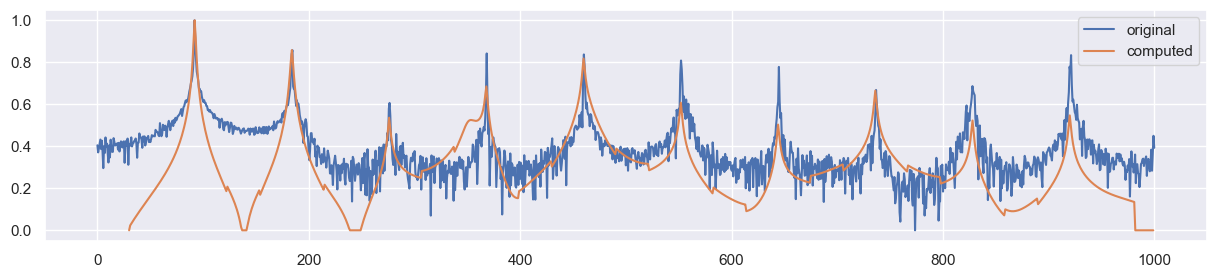

In [28]:

indir = "/Users/jane03/workspaces/music/didge/github-repo/evolutions/maveira2/results/report_1/"
infile = indir + "0_geo.txt"

infile = "/Users/jane03/workspaces/music/didge/didge-archive/geometries/malveira.json"
maveira = json.load(open(infile, "r"))
#[[0.0, 32.0], [83.35332871777914, 35.0162328995634], [177.9648752136909, 34.82690089056204], [281.83166112126344, 29.124969714659077], [367.35680173872487, 29.01183093695966], [475.301155472401, 30.081015724957382], [532.6586686684653, 46.784454958915724], [620.365614379913, 51.31551058009397], [712.8954813604888, 38.05346860949759], [814.2715130217262, 48.75212765476513], [921.0838306416952, 65.51753708883814], [1024.98881282807, 61.88195136143321], [1091.417201565728, 65.42744180973494], [1203.11178631251, 81.20715408526168], [1280.731228759826, 84.57169980021843], [1372.2120308140995, 93.08226266864497]]

cadsd = Geo(maveira).get_cadsd().get_ground_spektrum()

ground_freqs = np.array(list(cadsd.keys()))
ground_vol = np.array(list(cadsd.values()))
ground_vol /= ground_vol.max()

infile = "didgeridoo-samples/wav_short/4.wav"
freq, spectrum = do_fft(infile)
spectrum = np.log2(spectrum)

spectrum -= spectrum.min()
spectrum = spectrum / np.max(spectrum)

plt.plot(freq, spectrum, label="original")
plt.plot(ground_freqs, ground_vol, label="computed")
#plt.plot(cfreq, cvol, label="computed")
plt.legend()


In [9]:
notes = Geo(maveira).get_cadsd().get_notes()

freqs = notes.freq.to_numpy()
harmonics = np.array([i*freqs[0] for i in range(1,10)])

closest_harmonics = np.array([np.argmin(np.abs(freq-harmonics)) for freq in freqs])
notes["closest_harmonic_freq"] = harmonics[closest_harmonics]
notes["closest_harmonic"] = closest_harmonics +1
notes["diff_to_harmonic"] = harmonics[0:len(freqs)] - freqs

freq = freqs[2]
np.abs(freq-harmonics)
notes

,freq,impedance,rel_imp,note-number,cent-diff,note-name,closest_harmonic_freq,closest_harmonic,diff_to_harmonic
1880,92.1,2.263869e+07,1.000000,-27,7.476555,F#1,92.1,1,0.0
154,184.0,6.003849e+06,0.265203,-15,9.357309,F#2,184.2,2,0.2
321,351.0,4.552726e+06,0.201104,-4,-8.761008,F3,368.4,4,-74.7
434,464.0,4.323518e+06,0.190979,1,8.054462,A#4,460.5,5,-95.6
713,743.0,9.586301e+05,0.042345,9,-7.030424,F#4,736.8,8,-282.5


In [69]:
import scipy

infile = "didgeridoo-samples/wav_short/4.wav"
freq, spectrum = do_fft(infile)

def get_extrema_in_window(freq, spectrum, fmin, fmax):
    extrema = np.array(scipy.signal.argrelextrema(spectrum, np.greater)[0])
    window = np.array(list(filter(lambda i:freq[i]>fmin and freq[i]<fmax, extrema)))
    i = np.argmax(spectrum[window])    
    return freq[window][i], spectrum[window][i]

fundamental, _ = get_extrema_in_window(freq, spectrum, 1, 100)
extrema = [fundamental]
overtones = [fundamental]
for i in range(2,11):
    f, _ = get_extrema_in_window(freq, spectrum, i*fundamental-0.5*fundamental, i*fundamental+0.5*fundamental)
    extrema.append(f)
    overtones.append(i*fundamental)
    
df = pd.DataFrame({
    "extrema": extrema,
    "overtones": overtones
})
df["diff"] = df.extrema - df.overtones

print("difference between peaks in sound sample and in the harmonic overtones")
df.round(2)

difference between peaks in sound sample and in the harmonic overtones


,extrema,overtones,diff
0,91.91,91.91,0.00
1,184.52,183.83,0.70
2,276.44,275.74,0.70
3,368.35,367.66,0.70
4,460.27,459.57,0.70
5,552.18,551.48,0.70
6,644.79,643.40,1.39
7,736.70,735.31,1.39
8,827.92,827.23,0.70
9,921.23,919.14,2.09


In [92]:
infile = "../../../../didge-archive/audio-samples/malveira-neutral-sound.wav"
freq, spectrum = do_fft(infile)

fundamental, _ = get_extrema_in_window(freq, spectrum, 1, 100)
measured = [fundamental]
for i in range(2,11):
    f, _ = get_extrema_in_window(freq, spectrum, i*fundamental-0.5*fundamental, i*fundamental+0.5*fundamental)
    measured.append(f)
    
cadsd = Geo(maveira).get_cadsd().get_ground_spektrum()
ground_freqs = np.array(list(cadsd.keys()))
ground_vol = np.array(list(cadsd.values()))

computed = []
for i in range(1,11):
    f, _ = get_extrema_in_window(ground_freqs, ground_vol, i*fundamental-0.5*fundamental, i*fundamental+0.5*fundamental)
    computed.append(f)

df = pd.DataFrame({
    "measured": measured,
    "computed": computed
})
df["diff"] = df.measured - df.computed
df

,measured,computed,diff
0,93.957447,92,1.957447
1,188.595745,184,4.595745
2,282.553191,276,6.553191
3,376.510638,368,8.510638
4,471.148936,460,11.148936
5,565.106383,552,13.106383
6,659.063830,644,15.063830
7,755.744681,736,19.744681
8,846.978723,828,18.978723
9,941.617021,920,21.617021


In [85]:
!ls 

arusha-hand1.wav            malverira-hand1.wav
arusha-hand2.wav            nazare-hand1.wav
arusha-neutral-sound.wav    nazare-hand2.wav
arusha-short-song.wav       nazare-neutral-sound.wav
kizimkazi-hand1.wav         nazare-short-song.wav
kizimkazi-hand2.wav         open-didge-drags.wav
kizimkazi-neutral-sound.wav opendidge-hand1.wav
kizimkazi-short-song.wav    opendidge-hand2.wav
malveira-hand2.wav          opendidge-neutral-sound.wav
malveira-neutral-sound.wav  opendidge-short-song.wav
malveira-short-song.wav


In [102]:
volumes=[]
files=[]
for f in sorted(os.listdir(indir)):
    if f[-4:] != ".txt":
        continue
    path = os.path.join(indir, f)
    geo = json.load(open(path, "r"))
    
    vol = 0
    for i in np.arange(1, len(geo)):
        length = geo[i][0] - geo[i-1][0]
        vol += geo[i-1][1] * length
        vol += length * (geo[i][1]-geo[i-1][1]) / 2 
    
    files.append(f)
    volumes.append(vol)

sorted(range(len(files)), key=lambda x : volumes[x])


[3, 0, 4, 1, 8, 2, 9, 5, 7, 6]